# import library

In [8]:
# import 
import numpy as np
import pandas as pd
import os
from math import sqrt
from pathlib import Path
from tqdm import tqdm
tqdm.pandas()

import datetime

In [9]:
class DataSet:
    # クラス変数の定義
    DRIVE_DIR = r'/content/drive/MyDrive/Colab Notebooks/kaggle/H_and_M_Personalized_Fashion_Recommendations'
    INPUT_DIR = os.path.join(DRIVE_DIR, 'input')

    def __init__(self) -> None:
        # インスタンス変数(属性の初期化)
        self.ALL_ITEMS = []
        self.ALL_USERS = []
        self.df_val: pd.DataFrame
        pass

    def read_data(self, c_id_short: bool = True):

        # ファイルパスを用意
        csv_train = os.path.join(DataSet.INPUT_DIR, 'transactions_train.csv')
        csv_sub = os.path.join(DataSet.INPUT_DIR, 'sample_submission.csv')
        csv_users = os.path.join(DataSet.INPUT_DIR, 'customers.csv')
        csv_items = os.path.join(DataSet.INPUT_DIR, 'articles.csv')

        # データをDataFrame型で読み込み
        if c_id_short == True:
            # 実際の購買記録の情報
            self.df = pd.read_parquet(os.path.join(
                DataSet.DRIVE_DIR, 'transactions_train.parquet'))
            # dfのcustomer_idはshort版に加工されてるから、カラム名を変更しておく
            self.df.rename(
                columns={'customer_id': 'customer_id_short'}, inplace=True)

            # dfのarticle_idを文字列に為ておく?
            # 各顧客の情報(メタデータ)
            self.dfu = pd.read_parquet(os.path.join(
                DataSet.DRIVE_DIR, 'customers.parquet'))
            self.dfu.rename(
                columns={'customer_id': 'customer_id_short'}, inplace=True)
            # 各商品の情報(メタデータ)
            self.dfi = pd.read_parquet(os.path.join(
                DataSet.DRIVE_DIR, 'articles.parquet'))
        else:
            self.df = pd.read_csv(csv_train, dtype={'article_id': str},
                                  parse_dates=['t_dat']  # datetime型で読み込み
                                  )
            self.dfu = pd.read_csv(csv_users)  # 各顧客の情報(メタデータ)
            self.dfi = pd.read_csv(
                csv_items, dtype={'article_id': str})  # 各商品の情報(メタデータ)

            # customer_id_shortカラムを生成
            self.df['customer_id_short'] = self.df["customer_id"].apply(lambda s: int(s[-16:], 16)).astype("uint64")
            self.dfu['customer_id_short'] =self.dfu["customer_id"].apply(lambda s: int(s[-16:], 16)).astype("uint64")

        # price カラムを×10^3しておく...その方が、小数点以下と整数で分けやすい??
        self.df['price'] = self.df['price'] * (10 **3)

        # 提出用のサンプル
        self.df_sub = pd.read_csv(csv_sub)
        

        # customer_idカラムのみのpd.DataFrameを作っておく(たぶん色々便利なので)
        self.df_sub["customer_id_short"] = pd.DataFrame(
            self.df_sub["customer_id"].apply(lambda s: int(s[-16:], 16))).astype("uint64")
        self.cid = pd.DataFrame(self.df_sub["customer_id_short"])

    def read_data_sampled(self, sampling_percentage: float = 5):
        # ファイルパスを用意
        sampled_data_dir = os.path.join(DataSet.INPUT_DIR, 'sampling_dir')
        path_transactions = os.path.join(
            sampled_data_dir, f'transactions_train_sample{sampling_percentage}.csv.gz')
        path_article = os.path.join(
            sampled_data_dir, f'articles_train_sample{sampling_percentage}.csv.gz')
        path_customers = os.path.join(
            sampled_data_dir, f'customers_sample{sampling_percentage}.csv.gz')

        # インスタンス変数として読み込み
        self.df = pd.read_csv(path_transactions,
                              dtype={'article_id': str},
                              parse_dates=['t_dat']  # datetime型で読み込み
                              )
        # price カラムを×10^3しておく...その方が、小数点以下と整数で分けやすい??
        self.df['price'] = self.df['price'] * (10 **3)
        self.dfi = pd.read_csv(path_article, dtype={'article_id': str})
        self.dfu = pd.read_csv(path_customers)
        # df_subはそのまま
        csv_sub = os.path.join(DataSet.INPUT_DIR, 'sample_submission.csv')
        self.df_sub = pd.read_csv(csv_sub)
        # customer_id_shortカラムを作る.
        self.df_sub["customer_id_short"] = pd.DataFrame(
            self.df_sub["customer_id"].apply(lambda s: int(s[-16:], 16))).astype("uint64")

        # customer_idカラムのみのpd.DataFrameを作っておく(たぶん色々便利なので)
        self.cid = pd.DataFrame(self.dfu["customer_id_short"].copy())
        print(self.cid)

In [48]:
Colab_bool = False
# Load data
if Colab_bool==False:
    df_t = pd.read_csv(r'C:\Users\Masat\デスクトップ_Instead\webアプリ開発\H_and_M_Personalized_Fashion_Recommendations\input\transactions_train_sample5.csv.gz')
    df_i = pd.read_csv(r'C:\Users\Masat\デスクトップ_Instead\webアプリ開発\H_and_M_Personalized_Fashion_Recommendations\input\articles_train_sample5.csv.gz')
    df_u = pd.read_csv(r'C:\Users\Masat\デスクトップ_Instead\webアプリ開発\H_and_M_Personalized_Fashion_Recommendations\input\customers_sample5.csv.gz')

# 本番環境(=colab)では...
if Colab_bool :
    # DataSetオブジェクトの読み込み
    dataset = DataSet()
    # DataFrameとしてデータ読み込み
    dataset.read_data(c_id_short=True)

    # データをDataFrame型で読み込み
    df_t = dataset.df
    df_sub = dataset.df_sub # 提出用のサンプル
    df_u = dataset.dfu # 各顧客の情報(メタデータ)
    df_i = dataset.dfi # 各商品の情報(メタデータ)

# datetime型に変換
df_t['t_dat'] = pd.to_datetime(df_t['t_dat'])



# ユーザのコールドスタート問題に関して

In [4]:
# ユーザの活発性に関するメタデータ
df_u_activety = pd.read_csv(r'C:\Users\Masat\デスクトップ_Instead\webアプリ開発\H_and_M_Personalized_Fashion_Recommendations\input\metadata_customer_id.csv')
df_u_activety.head()

,customer_id,num_missing_months,lastest_inactive_months,active_status,num_transactions,cold_start_status,mean_transactions_in_active_month
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,7,0,active,6.0,cold_start,3.000000
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,5,2,inactive_in_2_months,34.0,non_cold_start,8.500000
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,6,0,active,14.0,non_cold_start,4.666667
3,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,7,1,inactive_in_1_month,7.0,cold_start,3.500000
4,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,8,0,active,2.0,cold_start,2.000000


In [5]:
print(df_u_activety.shape)
print(df_u_activety.nunique())

user_features_about_activity = [
    'num_missing_months', # 2020年にユーザーが取引をしていない月数
    'lastest_inactive_months', # テストセットで再登場する前にユーザーが非アクティブだった連続月数
    'active_status', # 5種のカテゴリ
        # active:2020年9月に購入有り, inactive_in_year: 2020年に購入無し, 
        # inactive_in_3_months_or_more:2020年7~9月に購入無し
        # inactive_in_2_months:2020年8~9月に購入無し
        # inactive_in_1_months:2020年9月に購入無し

    'num_transactions', # number of transactions in 2020
     'cold_start_status', # 2種のカテゴリ
    # cold_start:number of transactions <= 10 in 2020
    # non_cold_start: number of transactions > 10 in 2020
    
    'mean_transactions_in_active_month' # ユーザーが活動している月の平均トランザクション数
]


(1371980, 7)
customer_id                          1371980
num_missing_months                        10
lastest_inactive_months                    4
active_status                              5
num_transactions                         376
cold_start_status                          2
mean_transactions_in_active_month       1087
dtype: int64


(68599, 7)

In [6]:
df_u_activety['active_status'].value_counts()

inactive_in_year                509256
inactive_in_3_months_or_more    373171
active                          189510
inactive_in_1_month             174288
inactive_in_2_months            125755
Name: active_status, dtype: int64

In [25]:
# merge
df_t = pd.merge(
    df_t, df_i, on='article_id', how='left'
)

df_t = pd.merge(
    df_t, df_u, on='customer_id_short', how='left'
)


In [26]:
df_t.head()

,t_dat,customer_id_short,article_id,price,sales_channel_id,week,product_code,prod_name,product_type_no,product_type_name,...,section_name,garment_group_no,garment_group_name,detail_desc,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,2018-09-20,52397916724644664,638282001,0.022017,2,0,638282,33213,67,39,...,29,1019,1,41754,-1,-1,1,0,32,36155
1,2018-09-20,52397916724644664,684033003,0.030492,2,0,684033,12397,78,26,...,25,1019,1,20690,-1,-1,1,0,32,36155
2,2018-09-20,52397916724644664,617903013,0.022017,2,0,617903,1855,255,3,...,17,1005,0,2120,-1,-1,1,0,32,36155
3,2018-09-20,52397916724644664,617903009,0.022017,2,0,617903,1855,255,3,...,17,1005,0,2120,-1,-1,1,0,32,36155
4,2018-09-20,52397916724644664,661435002,0.084729,2,0,661435,7894,272,0,...,37,1016,11,3703,-1,-1,1,0,32,36155


# Create user metadata

In [49]:
df_t['t_dat'] = pd.to_datetime(df_t['t_dat'])
df_t['month'] = df_t['t_dat'].dt.month
df_t['year'] = df_t['t_dat'].dt.year
df_t.tail()

,t_dat,customer_id_short,article_id,price,sales_channel_id,week,month,year
1584945,2020-09-22,18378774341933120540,894780001,0.033881,2,104,9,2020
1584946,2020-09-22,18378774341933120540,894780001,0.033881,2,104,9,2020
1584947,2020-09-22,18378774341933120540,894780001,0.033881,2,104,9,2020
1584948,2020-09-22,18416046886745463528,903420001,0.030864,2,104,9,2020
1584949,2020-09-22,18416046886745463528,909059002,0.038593,2,104,9,2020


In [50]:
# 2020年だけ抽出する
df_t = df_t[df_t['year']==2020]
df_t.shape

(548462, 8)

In [51]:
# find inactive user
# まず全ユーザの各月のトランザクション回数をカウントする.
df_month_avg_item_per_u = df_t.groupby(
    by=['customer_id_short', 'month']
    )['price'].count().unstack().reset_index()
df_month_avg_item_per_u

month,customer_id_short,1,2,3,4,5,6,7,8,9
0,41046458195168,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN
1,366493139417506,4.0,2.0,NaN,NaN,NaN,NaN,2.0,1.0,NaN
2,690285180337957,1.0,1.0,NaN,1.0,16.0,1.0,8.0,2.0,3.0
3,964326548579219,4.0,3.0,13.0,NaN,10.0,NaN,NaN,3.0,7.0
4,1129941287921788,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
43046,18443445146963417717,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
43047,18443469385832386797,8.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43048,18444094233300082297,NaN,NaN,5.0,NaN,NaN,NaN,NaN,2.0,NaN
43049,18444695778382839691,6.0,NaN,6.0,NaN,6.0,NaN,8.0,NaN,NaN


In [52]:
# ユーザのデータとマージする
df_month_avg_item_per_u = pd.merge(
    df_u[['customer_id_short']], df_month_avg_item_per_u,
    on='customer_id_short', how='left'
)
df_month_avg_item_per_u

,customer_id_short,1,2,3,4,5,6,7,8,9
0,13338179932707194612,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN
1,10539115245177061704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
2,13492044323173700932,NaN,NaN,10.0,NaN,NaN,4.0,NaN,NaN,NaN
3,15434848986270337307,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,6.0
4,17189843200101857462,2.0,NaN,5.0,NaN,NaN,4.0,2.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
68594,17745320864196317137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68595,1626456802741939737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68596,14798607767814720145,5.0,NaN,NaN,NaN,NaN,4.0,2.0,3.0,NaN
68597,606762062865016222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
# トランザクション回数がゼロ回の月の数を算出する
df_month_avg_item_per_u['num_missing_months'] = df_month_avg_item_per_u.isnull().sum(axis=1)

df_month_avg_item_per_u

,customer_id_short,1,2,3,4,5,6,7,8,9,num_missing_months
0,13338179932707194612,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,8
1,10539115245177061704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,8
2,13492044323173700932,NaN,NaN,10.0,NaN,NaN,4.0,NaN,NaN,NaN,7
3,15434848986270337307,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,6.0,7
4,17189843200101857462,2.0,NaN,5.0,NaN,NaN,4.0,2.0,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...
68594,17745320864196317137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
68595,1626456802741939737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
68596,14798607767814720145,5.0,NaN,NaN,NaN,NaN,4.0,2.0,3.0,NaN,5
68597,606762062865016222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9


In [54]:
# num_missing_months=9は、「2020年に購入ゼロのユーザ」を意味する。
num_missing_year = len(df_month_avg_item_per_u[df_month_avg_item_per_u['num_missing_months'] == 9])
print(num_missing_year)
print(num_missing_year/len(df_u) * 100, 'percent' )

25548
37.24252540124491 percent


In [55]:
# 「各月の購入回数」の欠損値を0埋めする
df_month_avg_item_per_u = df_month_avg_item_per_u.fillna(0)
df_month_avg_item_per_u

,customer_id_short,1,2,3,4,5,6,7,8,9,num_missing_months
0,13338179932707194612,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,8
1,10539115245177061704,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,8
2,13492044323173700932,0.0,0.0,10.0,0.0,0.0,4.0,0.0,0.0,0.0,7
3,15434848986270337307,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,6.0,7
4,17189843200101857462,2.0,0.0,5.0,0.0,0.0,4.0,2.0,0.0,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...
68594,17745320864196317137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
68595,1626456802741939737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
68596,14798607767814720145,5.0,0.0,0.0,0.0,0.0,4.0,2.0,3.0,0.0,5
68597,606762062865016222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9


In [31]:
df_month_avg_item_per_u.columns.difference(['customer_id_short', 'num_missing_months'])

Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 'customer_id_short'], dtype='object')

In [32]:

def cal_inactive_months(x:pd.Series):
    """Applyメソッド用。

    Parameters
    ----------
    x : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """
    if x[9] > 0:
        # 9月に購入有りのユーザ
        return 0
    elif x[9] == 0 and x[8] > 0:
        # 9月に購入なし、8月に購入有りのユーザ
        return 1
    elif x[9] == 0 and x[8] == 0 and x[7] > 0:
        # 8,9月に購入なし、7月に購入有りのユーザ
        return 2
    elif x[9] == 0 and x[8] == 0 and x[7] == 0:
        # 直近の連続3ヶ月以上の非アクティブユーザーは、3
        return 3
        
    else:
        # その他なんてある？？漏れなくない？
        return 4

df_month_avg_item_per_u['lastest_inactive_months'] = (
    df_month_avg_item_per_u.apply(lambda x: cal_inactive_months(x), axis=1)
)

df_month_avg_item_per_u.head()

,customer_id_short,1,2,3,4,5,6,7,8,9,num_missing_months,lastest_inactive_months
0,13338179932707194612,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,8,2
1,10539115245177061704,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,8,1
2,13492044323173700932,0.0,0.0,10.0,0.0,0.0,4.0,0.0,0.0,0.0,7,3
3,15434848986270337307,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,6.0,7,0
4,17189843200101857462,2.0,0.0,5.0,0.0,0.0,4.0,2.0,0.0,0.0,5,2


In [33]:
# やっぱり4はなかった笑
df_month_avg_item_per_u['lastest_inactive_months'].unique()

array([2, 1, 3, 0], dtype=int64)

9    25548
8    17951
7     8850
6     5847
5     3958
4     2608
3     1754
2     1071
1      650
0      362
Name: num_missing_months, dtype: int64
count    68599.000000
mean         7.417717
std          1.906367
min          0.000000
25%          7.000000
50%          8.000000
75%          9.000000
max          9.000000
Name: num_missing_months, dtype: float64


<AxesSubplot:>

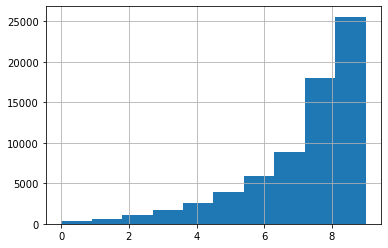

In [35]:
# このセルで、50％のユーザーが8ヶ月以上前に失踪していることがわかる。
# これは、我々のデータにおけるもう一つの課題である
print(df_month_avg_item_per_u['num_missing_months'].value_counts())
print(df_month_avg_item_per_u['num_missing_months'].describe())
df_month_avg_item_per_u['num_missing_months'].hist()

3    44126
0     9467
1     8672
2     6334
Name: lastest_inactive_months, dtype: int64
count    68599.000000
mean         2.240820
std          1.124146
min          0.000000
25%          1.000000
50%          3.000000
75%          3.000000
max          3.000000
Name: lastest_inactive_months, dtype: float64


<AxesSubplot:>

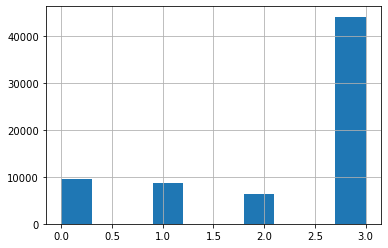

In [37]:
# 次のセルでは、64%のユーザーが最近3ヶ月間（9月、8月、7月）に姿を消した後、
# 再びtestdataに現れていることがわかる。
print(df_month_avg_item_per_u['lastest_inactive_months'].value_counts())
print(df_month_avg_item_per_u['lastest_inactive_months'].describe())
df_month_avg_item_per_u['lastest_inactive_months'].hist()

## Create a dataframe for inactive user

In [38]:
# 'active_status'カラムを作る
def create_active_status(x:pd.Series):
    if x['num_missing_months'] >= 9:
        return 'inactive_in_year'
    elif x['lastest_inactive_months'] == 3:
        return 'inactive_in_3_months_or_more'
    elif x['lastest_inactive_months'] == 2:
        return 'inactive_in_2_months'
    elif x['lastest_inactive_months'] == 1:
        return 'inactive_in_1_month'
    else:
        # 基本的にはx['lastest_inactive_months'] == 0のユーザ?
        return 'active'

df_month_avg_item_per_u['active_status'] = (
    df_month_avg_item_per_u.apply(func=create_active_status, axis=1)
)
df_month_avg_item_per_u.head()

,customer_id_short,1,2,3,4,5,6,7,8,9,num_missing_months,lastest_inactive_months,active_status
0,13338179932707194612,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,8,2,inactive_in_2_months
1,10539115245177061704,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,8,1,inactive_in_1_month
2,13492044323173700932,0.0,0.0,10.0,0.0,0.0,4.0,0.0,0.0,0.0,7,3,inactive_in_3_months_or_more
3,15434848986270337307,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,6.0,7,0,active
4,17189843200101857462,2.0,0.0,5.0,0.0,0.0,4.0,2.0,0.0,0.0,5,2,inactive_in_2_months


In [ ]:
# 

In [40]:
# ユーザのコールドスタートを評価するメタデータ
df_active_user = df_month_avg_item_per_u[['customer_id_short', 'num_missing_months', 'lastest_inactive_months', 'active_status']].copy()
df_active_user.head()

,customer_id_short,num_missing_months,lastest_inactive_months,active_status
0,13338179932707194612,8,2,inactive_in_2_months
1,10539115245177061704,8,1,inactive_in_1_month
2,13492044323173700932,7,3,inactive_in_3_months_or_more
3,15434848986270337307,7,0,active
4,17189843200101857462,5,2,inactive_in_2_months


## Find coldstart customer

In [41]:
# まず、トランザクションの数を数える。
# トランザクション数が10未満のユーザは、コールドスタートユーザと呼ぶ。
# このようなユーザーは、データが少なすぎて正しいレコメンデーションができないユーザー。
df_avg_item_per_u = df_t.groupby(['customer_id_short'])['price'].count().reset_index()
df_avg_item_per_u.columns = ['customer_id_short', 'num_transactions']
df_avg_item_per_u.head()


,customer_id_short,num_transactions
0,41046458195168,4
1,366493139417506,9
2,690285180337957,33
3,964326548579219,40
4,1129941287921788,5


In [45]:
# 2020年にトランザクションがないユーザーがいる。
# これをデータフレームに追加する
# ＋トランザクション数を0としてラベル付けする。
df_avg_item_per_u = pd.merge(
    df_u[['customer_id_short']], df_avg_item_per_u,
    on='customer_id_short', how='left'
)
df_avg_item_per_u = df_avg_item_per_u.fillna(0)
df_avg_item_per_u

,customer_id_short,num_transactions
0,13338179932707194612,5.0
1,10539115245177061704,2.0
2,13492044323173700932,14.0
3,15434848986270337307,8.0
4,17189843200101857462,13.0
...,...,...
68594,17745320864196317137,0.0
68595,1626456802741939737,0.0
68596,14798607767814720145,14.0
68597,606762062865016222,0.0


In [46]:
# Binで分ける
df_avg_item_per_u['num_transactions'].value_counts(bins=[-1, 0, 10, 100, 1000])

(0.0, 10.0]        27248
(-1.001, 0.0]      25548
(10.0, 100.0]      15558
(100.0, 1000.0]      245
Name: num_transactions, dtype: int64

In [62]:
# 2020年のトランザクション数が10未満のユーザをコールドスタートユーザと見なす
def create_cold_start_status(x:pd.Series):
    if x['num_transactions'] >= 10:
        return 'non_cold_start'
    elif x['num_transactions'] < 10:
        return 'cold_start'

df_avg_item_per_u['cold_start_status'] = (
    df_avg_item_per_u.apply(func=create_cold_start_status, axis=1)
)
df_coldstart_user = df_avg_item_per_u.copy()
df_coldstart_user

,customer_id_short,num_transactions,cold_start_status
0,13338179932707194612,5.0,cold_start
1,10539115245177061704,2.0,cold_start
2,13492044323173700932,14.0,non_cold_start
3,15434848986270337307,8.0,cold_start
4,17189843200101857462,13.0,non_cold_start
...,...,...,...
68594,17745320864196317137,0.0,cold_start
68595,1626456802741939737,0.0,cold_start
68596,14798607767814720145,14.0,non_cold_start
68597,606762062865016222,0.0,cold_start


## frequent transaction of user in monthについて

In [56]:
df_month_avg_item_per_u = df_t.groupby(['customer_id_short', 'month'])['price'].count().unstack().reset_index()
df_month_avg_item_per_u

month,customer_id_short,1,2,3,4,5,6,7,8,9
0,41046458195168,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN
1,366493139417506,4.0,2.0,NaN,NaN,NaN,NaN,2.0,1.0,NaN
2,690285180337957,1.0,1.0,NaN,1.0,16.0,1.0,8.0,2.0,3.0
3,964326548579219,4.0,3.0,13.0,NaN,10.0,NaN,NaN,3.0,7.0
4,1129941287921788,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
43046,18443445146963417717,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
43047,18443469385832386797,8.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43048,18444094233300082297,NaN,NaN,5.0,NaN,NaN,NaN,NaN,2.0,NaN
43049,18444695778382839691,6.0,NaN,6.0,NaN,6.0,NaN,8.0,NaN,NaN


In [57]:
def find_active_month(x):
    float_x = x.values[1:].astype(float)
    return float_x[~np.isnan(float_x)]
df_month_avg_item_per_u['transactions_in_active_month'] = df_month_avg_item_per_u.apply(
    lambda x: find_active_month(x), axis=1)
df_month_avg_item_per_u

month,customer_id_short,1,2,3,4,5,6,7,8,9,transactions_in_active_month
0,41046458195168,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,[4.0]
1,366493139417506,4.0,2.0,NaN,NaN,NaN,NaN,2.0,1.0,NaN,"[4.0, 2.0, 2.0, 1.0]"
2,690285180337957,1.0,1.0,NaN,1.0,16.0,1.0,8.0,2.0,3.0,"[1.0, 1.0, 1.0, 16.0, 1.0, 8.0, 2.0, 3.0]"
3,964326548579219,4.0,3.0,13.0,NaN,10.0,NaN,NaN,3.0,7.0,"[4.0, 3.0, 13.0, 10.0, 3.0, 7.0]"
4,1129941287921788,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,[5.0]
...,...,...,...,...,...,...,...,...,...,...,...
43046,18443445146963417717,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,[2.0]
43047,18443469385832386797,8.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[8.0, 5.0]"
43048,18444094233300082297,NaN,NaN,5.0,NaN,NaN,NaN,NaN,2.0,NaN,"[5.0, 2.0]"
43049,18444695778382839691,6.0,NaN,6.0,NaN,6.0,NaN,8.0,NaN,NaN,"[6.0, 6.0, 6.0, 8.0]"


In [58]:
df_month_avg_item_per_u['mean_transactions_in_active_month'] = df_month_avg_item_per_u.apply(
    lambda x: x['transactions_in_active_month'].mean(), axis=1)
df_month_avg_item_per_u

month,customer_id_short,1,2,3,4,5,6,7,8,9,transactions_in_active_month,mean_transactions_in_active_month
0,41046458195168,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,[4.0],4.000000
1,366493139417506,4.0,2.0,NaN,NaN,NaN,NaN,2.0,1.0,NaN,"[4.0, 2.0, 2.0, 1.0]",2.250000
2,690285180337957,1.0,1.0,NaN,1.0,16.0,1.0,8.0,2.0,3.0,"[1.0, 1.0, 1.0, 16.0, 1.0, 8.0, 2.0, 3.0]",4.125000
3,964326548579219,4.0,3.0,13.0,NaN,10.0,NaN,NaN,3.0,7.0,"[4.0, 3.0, 13.0, 10.0, 3.0, 7.0]",6.666667
4,1129941287921788,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,[5.0],5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
43046,18443445146963417717,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,[2.0],2.000000
43047,18443469385832386797,8.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[8.0, 5.0]",6.500000
43048,18444094233300082297,NaN,NaN,5.0,NaN,NaN,NaN,NaN,2.0,NaN,"[5.0, 2.0]",3.500000
43049,18444695778382839691,6.0,NaN,6.0,NaN,6.0,NaN,8.0,NaN,NaN,"[6.0, 6.0, 6.0, 8.0]",6.500000


count    43051.000000
mean         4.561642
std          3.951551
min          1.000000
25%          2.000000
50%          3.500000
75%          5.800000
max        109.000000
Name: mean_transactions_in_active_month, dtype: float64


<AxesSubplot:>

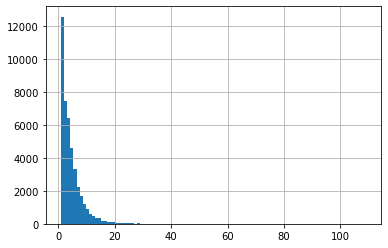

In [59]:
print(df_month_avg_item_per_u.mean_transactions_in_active_month.describe())
df_month_avg_item_per_u.mean_transactions_in_active_month.hist(bins=100)

In [60]:
df_transaction_frequent = df_month_avg_item_per_u[['customer_id_short', 'mean_transactions_in_active_month']].copy()

## dataframe for all metadata for user: active status/cold start status

In [63]:
result = pd.merge(df_active_user, df_coldstart_user,
on='customer_id_short', how='outer')
result = pd.merge(
    result, df_transaction_frequent, 
    on='customer_id_short', how='outer'
)
result

,customer_id_short,num_missing_months,lastest_inactive_months,active_status,num_transactions,cold_start_status,mean_transactions_in_active_month
0,13338179932707194612,8,2,inactive_in_2_months,5.0,cold_start,5.000000
1,10539115245177061704,8,1,inactive_in_1_month,2.0,cold_start,2.000000
2,13492044323173700932,7,3,inactive_in_3_months_or_more,14.0,non_cold_start,7.000000
3,15434848986270337307,7,0,active,8.0,cold_start,4.000000
4,17189843200101857462,5,2,inactive_in_2_months,13.0,non_cold_start,3.250000
...,...,...,...,...,...,...,...
68594,17745320864196317137,9,3,inactive_in_year,0.0,cold_start,NaN
68595,1626456802741939737,9,3,inactive_in_year,0.0,cold_start,NaN
68596,14798607767814720145,5,1,inactive_in_1_month,14.0,non_cold_start,3.500000
68597,606762062865016222,9,3,inactive_in_year,0.0,cold_start,NaN


In [ ]:
result.to_csv('metadata_customer_id.csv', index=False)